# TP2 : Interação e Concorrência

Cada grupo de estudantes tem um número atribuído e pretendemos utilizar um algoritmo quântico para encontrar o nosso número.
O nosso grupo de trabalho é o 1 e usaremos o algoritmo de Grover para o encontrar numa lista de 8 possíveis.
Assim, para representação dos números possíveis (0 a 7) teremos 3 qubits ($2^{3}=8$) e pretendemos encontrar a representação binária de 1 (001).

In [1]:
from qiskit import *
%matplotlib inline
from qiskit.tools.visualization import *
import math as m

In [2]:
backend_state = Aer.get_backend("statevector_simulator")
backend_unitary = Aer.get_backend('unitary_simulator')
backend = Aer.get_backend("qasm_simulator")

In [3]:
def intersperse(iterable, delimiter):
    it = iter(iterable)
    yield next(it)
    for x in it:
        yield delimiter
        yield x

def concat_circuits(circuits, barrier=None):
    if barrier:
        circuits = intersperse(circuits, barrier)
    
    ret = QuantumCircuit()
    for circuit in circuits:
        ret += circuit
    return ret

def run(circuit, backend, **kwargs):
    if type(backend) is str:
        backend = Aer.get_backend(backend)
    return execute(circuit, backend, **kwargs).result()

def bloch_sphere(circuit, result):
    return plot_bloch_multivector(result.get_statevector(circuit))

def state_city(circuit, result):
    return plot_state_city(result.get_statevector(circuit))

def state_hinton(circuit, result):
    return plot_state_hinton(result.get_statevector(circuit))

def state_qsphere(circuit, result):
    return plot_state_qsphere(result.get_statevector(circuit))

def histogram(circuit, result):
    return plot_histogram(result.get_counts(circuit))

## 1. Inicialização
Pretendemos que todos os estados sejam verificados portanto criamos uma sobreposição uniforme de todas as possibilidades aplicando um Hadamard a cada qubit.   

$$ \frac{1}{\sqrt{N}} \sum_{x_i} \lvert x_i \rangle$$, sendo $N = 2^3 = 8$

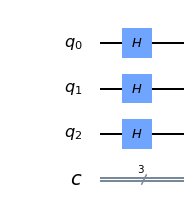

In [4]:
n = 3 # nº de bits
N = 2 ** n

cr = ClassicalRegister(n, 'c')
qr = QuantumRegister(n, 'q')

barrier = QuantumCircuit(qr, cr)
barrier.barrier()

init = QuantumCircuit(qr, cr)
init.h(qr)
init.draw('mpl')

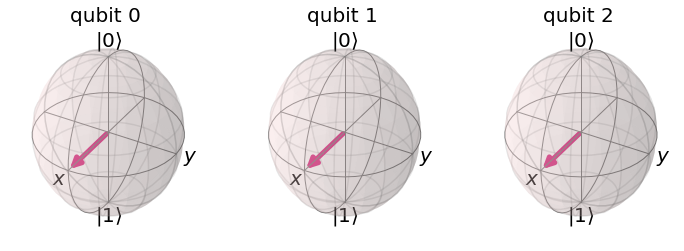

In [5]:
result = run(init, backend_state)
bloch_sphere(init, result)

Como podemos verificar, cada qubit está no estado de sobreposição |+> tendo igual probabilidade de ocorrer |0> como |1>.
Assim, todos os resultados têm igual probabilidade de ocorrer como podemos verificar na matriz seguinte.

In [6]:
result.get_statevector().real

array([0.35355339, 0.35355339, 0.35355339, 0.35355339, 0.35355339,
       0.35355339, 0.35355339, 0.35355339])

## 2. Oráculo
Pretendemos assinalar o nosso número de grupo mudando a fase da componente |001> **TODO** . Para isto optámos por um oráculo de fase que evita usar um qubit auxiliar diminuindo os erros na execução.   
O oráculo de fase consiste em selecionar a componente pretendida (|001>), aplicar um CCZ e reverter a seleção aplicada anteriormente.   
Uma vez que o operador CCZ não existe em qiskit decompusemo-lo em $(I \otimes I \otimes H) \cdot CNOT \cdot (I \otimes I \otimes H)$.   

$$-\alpha_{001} \lvert 001 \rangle + \beta \sum_{x_i \neq 001}\lvert x_i \rangle$$ 

In [7]:
def ccZ(circuit, c1, c2, t):
    circuit.h(t)
    circuit.ccx(c1, c2, t)
    circuit.h(t)
    
def phase_oracle(circuit, qr):
    circuit.x(qr[0])
    circuit.x(qr[1])
    ccZ(circuit, qr[0], qr[1], qr[2])
    circuit.x(qr[0])
    circuit.x(qr[1])

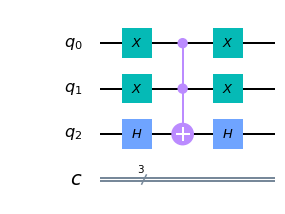

In [8]:
oracle = QuantumCircuit(qr, cr)
phase_oracle(oracle, qr)
oracle.draw('mpl')

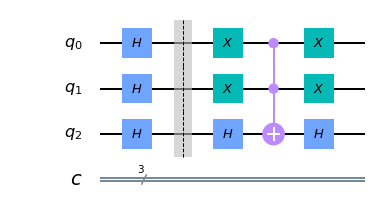

In [9]:
circuit = concat_circuits([ init, oracle ], barrier=barrier)
circuit.draw('mpl')

In [10]:
result = run(circuit, backend_state)
result.get_statevector(circuit).real

array([ 0.35355339,  0.35355339,  0.35355339,  0.35355339, -0.35355339,
        0.35355339,  0.35355339,  0.35355339])

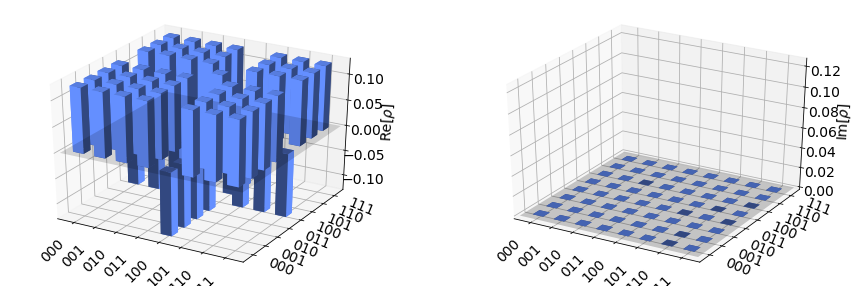

In [11]:
state_city(circuit, result)

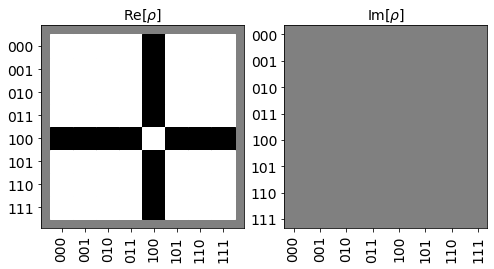

In [12]:
state_hinton(circuit, result)

Como se pode verificar a componente |100> (que representa o |001> pretendido) manteve a amplitude mas alterou a fase, tal como pretendíamos.

## 3. Amplificação

Apesar da mudança de fase, neste momento mantemos as probabilidades iguais para todos casos, o que não nos ajuda muito para o que pretendemos.
O objetivo desta secção é aumentar a probabilidade de obtermos o resultado pretendido.
Para isso, invertemos e aumentamos a amplitude da componente pretendida em torno da média das amplitudes ($A$) e simultaneamente reduzimos a amplitude das restantes componentes de forma uniforme.

$$(2A + \alpha_{001})\lvert 001 \rangle + (2A-\beta)\sum_{x_i\neq 001} \lvert x_i \rangle $$

In [13]:
def diffuser(circuit, qr):
    circuit.h(qr)
    circuit.x(qr)
    ccZ(circuit, qr[0], qr[1], qr[2])
    circuit.x(qr)
    circuit.h(qr)

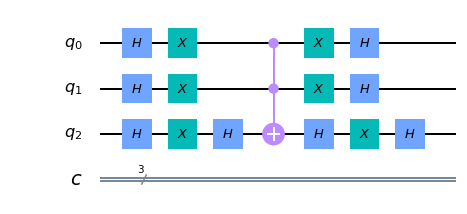

In [14]:
amplifier = QuantumCircuit(qr, cr)
diffuser(amplifier, qr)

amplifier.draw('mpl')

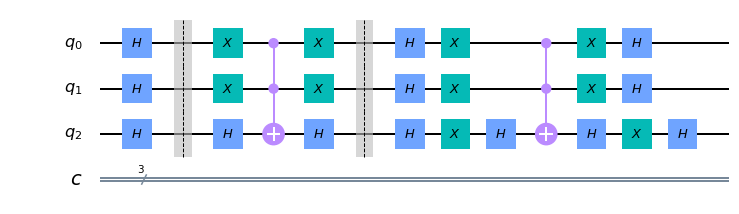

In [15]:
circuit = concat_circuits([ init, oracle, amplifier ], barrier=barrier)
circuit.draw('mpl')

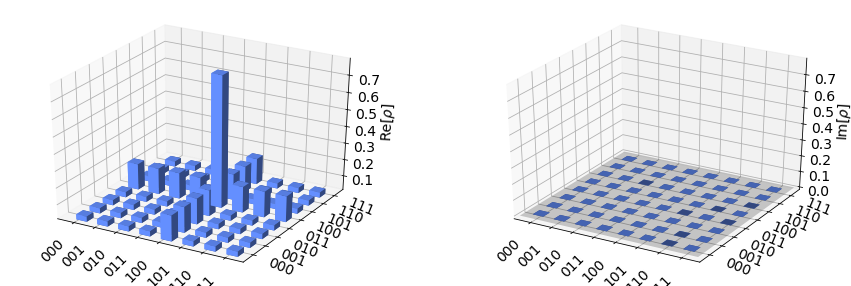

In [16]:
result = run(circuit, backend_state)
state_city(circuit, result)

Verificamos que a magnitude da componente |001> foi aumentada.

## 4. Medição
A medição é a projeção do estado quântico de cada um dos qubits para um bit clássico.
Ao ser medido, cada qubit colapsa para um dos estados possíveis, não sendo mais possível reconstruir o estado quântico inicial.

Apresentamos o circuito com as 4 secções referidas separadas por barreiras:

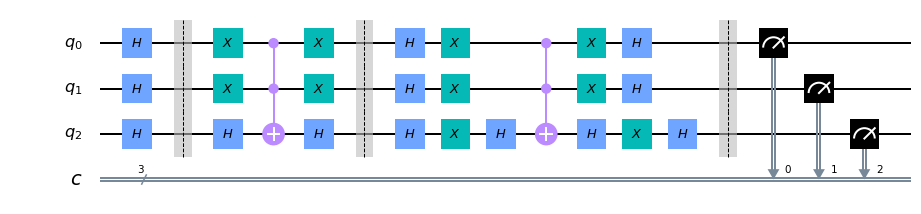

In [17]:
measurements = QuantumCircuit(qr, cr)
measurements.measure(qr, cr)

circuit = concat_circuits([ init, oracle, amplifier, measurements ], barrier=barrier)
circuit.draw('mpl')

### O iterador de Grover
Antes de fazermos as medições podemos melhorar a probabilidade de medirmos o valor pretendido.
Para isso, iremos repetir o iterador de Grover que consiste em aplicar o oráculo e a amplificação.
Lov Grover definiu que o número ideal de iterações é aproximadamente $\frac{\pi}{4}\sqrt{N}$, algo que podemos verificar de seguida.

In [18]:
times = round((m.pi/4) * m.sqrt(N))
times

2

### Uma iteração

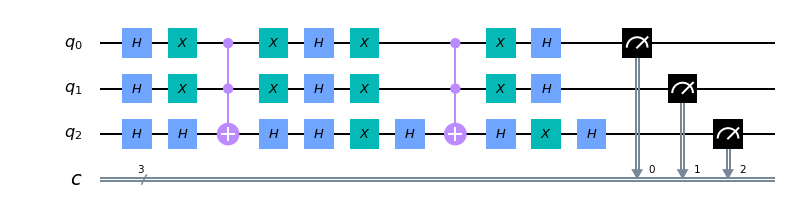

In [19]:
circuit = concat_circuits([ init ] + ([ oracle, amplifier ] * 1) + [ measurements ])
circuit.draw('mpl')

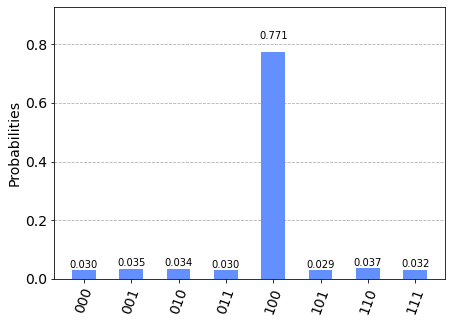

In [20]:
result = run(circuit, backend)
fst_loop_counts = result.get_counts(circuit)
plot_histogram(fst_loop_counts)

### Duas iterações

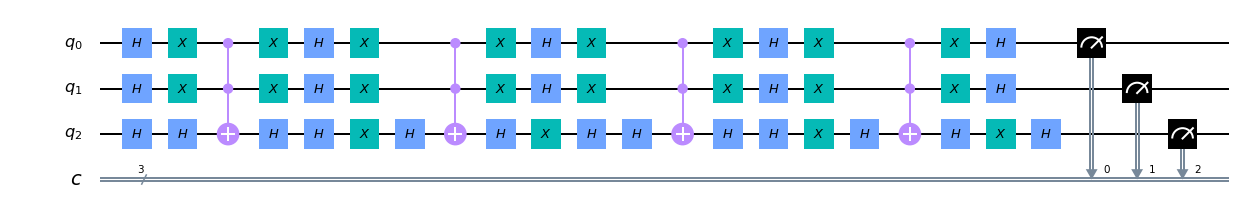

In [21]:
circuit = concat_circuits([ init ] + ([ oracle, amplifier ] * 2) + [ measurements ])
circuit.draw('mpl')

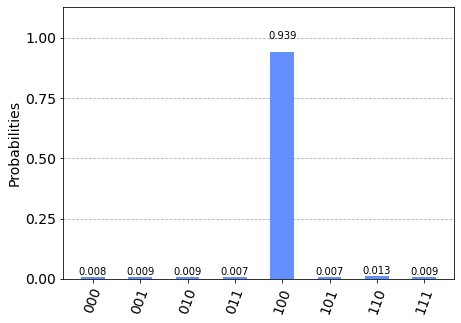

In [22]:
result = run(circuit, backend)
snd_loop_counts = result.get_counts(circuit)
plot_histogram(snd_loop_counts)

### Três iterações

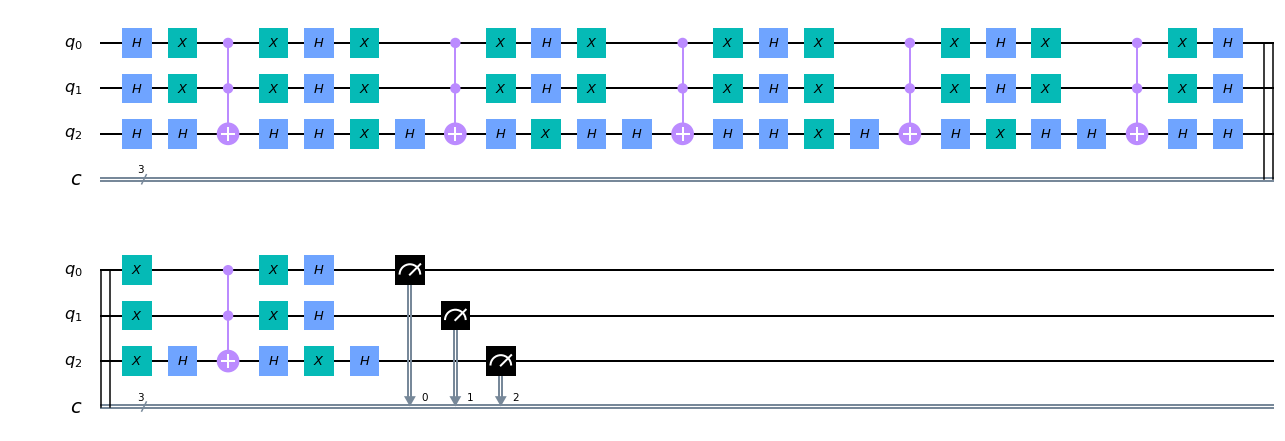

In [23]:
circuit = concat_circuits([ init ] + ([ oracle, amplifier ] * 3) + [ measurements ])
circuit.draw('mpl')

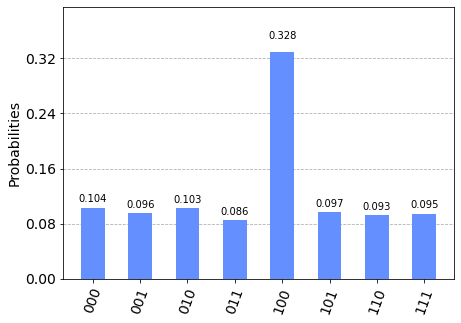

In [24]:
result = run(circuit, backend)
trd_loop_counts = result.get_counts(circuit)
plot_histogram(trd_loop_counts)

### Análise de resultados

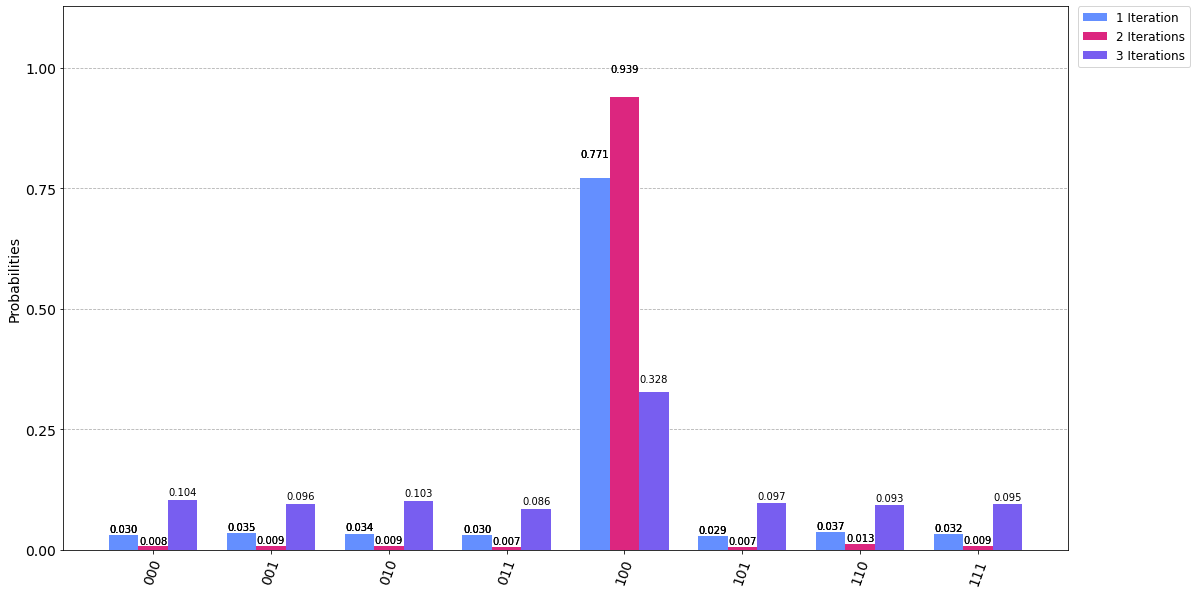

In [25]:
plot_histogram([ fst_loop_counts, snd_loop_counts, trd_loop_counts ], legend=[ "1 Iteration", "2 Iterations", "3 Iterations" ], figsize=(18, 10))

Como se pode verificar, houve um aumento significativo entre aplicar uma e duas iterações, no entanto ao aplicar uma terceira há uma diminuição substancial.

# Optimização do circuito

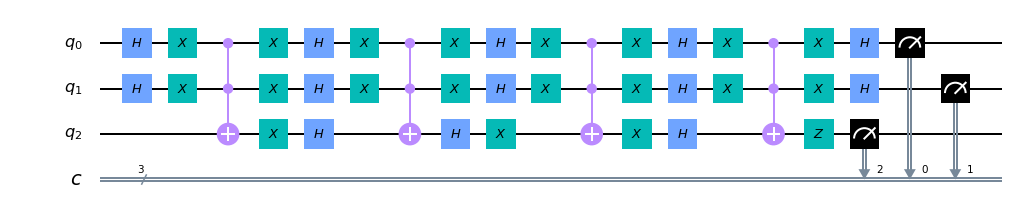

In [26]:
cr = ClassicalRegister(n, 'c')
qr = QuantumRegister(n, 'q')

qc_short = QuantumCircuit(qr, cr)

qc_short.h([ qr[0], qr[1] ])
qc_short.x([ qr[0], qr[1] ])
#qc_short.h(qr[2])
#qc_short.h(qr[2])

############

qc_short.ccx(qr[0], qr[1], qr[2])
qc_short.x([ qr[0], qr[1] ])
qc_short.h([ qr[0], qr[1] ])
qc_short.x([ qr[0], qr[1] ])

if False:
    qc_short.h(qr[2])
    qc_short.z(qr[2])
else:
    qc_short.x(qr[2])
    qc_short.h(qr[2])

############

qc_short.ccx(qr[0], qr[1], qr[2])
qc_short.x([ qr[0], qr[1] ])
qc_short.h([ qr[0], qr[1] ])
qc_short.x([ qr[0], qr[1] ])

if False:
    qc_short.z(qr[2])
    qc_short.h(qr[2])
else:
    qc_short.h(qr[2])
    qc_short.x(qr[2])

############

qc_short.ccx(qr[0], qr[1], qr[2])
qc_short.x([ qr[0], qr[1] ])
qc_short.h([ qr[0], qr[1] ])
qc_short.x([ qr[0], qr[1] ])

if False:
    qc_short.h(qr[2])
    qc_short.z(qr[2])
else:
    qc_short.x(qr[2])
    qc_short.h(qr[2])

############

qc_short.ccx(qr[0], qr[1], qr[2])
qc_short.x([ qr[0], qr[1] ])
qc_short.h([ qr[0], qr[1] ])
qc_short.z(qr[2])

#qc_short.barrier()

qc_short.measure(qr, cr)

qc_short.draw('mpl')

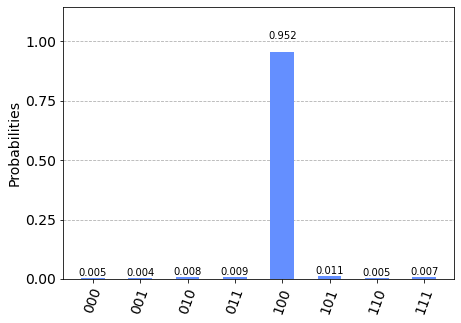

In [27]:
result = run(qc_short, backend)
histogram(qc_short, result)